## Problem Statement
### HMMs and Viterbi algorithm for POS tagging

You have learnt to build your own HMM-based POS tagger and implement the Viterbi algorithm using the Penn Treebank training corpus. The vanilla Viterbi algorithm we had written had resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

In this assignment, you need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques. Though there could be multiple ways to solve this problem, you may use the following hints:

* Which tag class do you think most unknown words belong to? Can you identify rules (e.g. based on morphological cues) that can be used to tag unknown words? You may define separate python functions to exploit these rules so that they work in tandem with the original Viterbi algorithm.

* Why does the Viterbi algorithm choose a random tag on encountering an unknown word? Can you modify the Viterbi algorithm so that it considers only one of the transition or emission probabilities for unknown words?

### Goals

You can split the Treebank dataset into train and validation sets. Please use a sample size of 95:5 for training: validation sets, i.e. keep the validation size small, else the algorithm will need a very high amount of runtime.

You need to accomplish the following in this assignment:

* Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
* Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
* Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
* List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import math
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 400)

In [2]:
#nltk.download('universal_tagset')

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
#Checking the tagged data
nltk_data[:5]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

__Splitting data into training and validation set in the ratio 95:5__

In [5]:
# split data into training and validation set in the ratio 95:5
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, train_size=0.95, test_size=0.05)

print("Length of Training set:",len(train_set))
print("Length of Test set:",len(test_set))
print("\n")
print("Lets have a glimpse of training set!!\n\n",train_set[:5])

Length of Training set: 3718
Length of Test set: 196


Lets have a glimpse of training set!!

 [[('``', '.'), ('If', 'ADP'), ('you', 'PRON'), ('were', 'VERB'), ('a', 'DET'), ('short-term', 'ADJ'), ('investor', 'NOUN'), (',', '.'), ('you', 'PRON'), ('might', 'VERB'), ('be', 'VERB'), ('more', 'ADV'), ('leery', 'ADJ'), ('about', 'ADP'), ('program', 'NOUN'), ('trading', 'NOUN'), ('.', '.'), ("''", '.')], [('``', '.'), ('The', 'DET'), ('company', 'NOUN'), ('does', 'VERB'), ('not', 'ADV'), ('feel', 'VERB'), ('that', 'ADP'), ('it', 'PRON'), ('or', 'CONJ'), ('any', 'DET'), ('of', 'ADP'), ('the', 'DET'), ('individuals', 'NOUN'), ('violated', 'VERB'), ('any', 'DET'), ('criminal', 'ADJ'), ('statute', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('company', 'NOUN'), ('expects', 'VERB'), ('full', 'ADJ'), ('vindication', 'NOUN'), ('in', 'ADP'), ('court', 'NOUN'), ('.', '.'), ("''", '.')], [('The', 'DET'), ('managers', 'NOUN'), ("'", 'PRT'), ('index', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-147', '

In [6]:
# Getting list of tagged words(both train_set and test_set)
train_tagged_words = [tup for sent in train_set for tup in sent]
print("Length of Training set tagged words:",len(train_tagged_words))

test_tagged_words = [tup for sent in test_set for tup in sent]
print("Length of Test set tagged words:",len(test_tagged_words))

Length of Training set tagged words: 95526
Length of Test set tagged words: 5150


In [7]:
#Have a look at the tagged_words in train set
train_tagged_words[:10]

[('``', '.'),
 ('If', 'ADP'),
 ('you', 'PRON'),
 ('were', 'VERB'),
 ('a', 'DET'),
 ('short-term', 'ADJ'),
 ('investor', 'NOUN'),
 (',', '.'),
 ('you', 'PRON'),
 ('might', 'VERB')]

In [8]:
# Vocabulary
train_tokens = [t[0] for t in train_tagged_words]
train_vocab_set = set(train_tokens)
print("Training set Vocabulary length:",len(train_vocab_set))

# Unique POS tags training set
train_POS_tag = [t[1] for t in train_tagged_words]
train_POS_tag_set = set(train_POS_tag)
print("Unique POS tags:",len(train_POS_tag_set))
print("List of unique tags:",train_POS_tag_set)

Training set Vocabulary length: 12044
Unique POS tags: 12
List of unique tags: {'.', 'NOUN', 'CONJ', 'ADP', 'VERB', 'PRT', 'ADJ', 'X', 'ADV', 'DET', 'PRON', 'NUM'}


### Build the vanilla Viterbi based POS tagger

#### Emission Probabilities

In [9]:
# compute word given tag: Emission Probability

def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Transition Probabilities 

In [10]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [11]:
# Computing P(w/t) and storing in Tags x Vocabulary matrix. 
# Matrix with dimension of len(train_POS_tag_set) X len(train_vocab_set)

len_POS_tags = len(train_POS_tag_set)
len_vocab = len(train_vocab_set)


In [12]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len_POS_tags, len_POS_tags), dtype='float32')
for i, t1 in enumerate(list(train_POS_tag_set)):
    for j, t2 in enumerate(list(train_POS_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [13]:
# Lets have a look at the tags_matrix
tags_matrix

array([[9.14119855e-02, 2.22363293e-01, 5.88555373e-02, 9.15026739e-02,
        8.86913911e-02, 2.35784892e-03, 4.50711884e-02, 2.72966363e-02,
        5.32329753e-02, 1.73846021e-01, 6.54756501e-02, 7.98041150e-02],
       [2.38003001e-01, 2.63733059e-01, 4.24692072e-02, 1.77478895e-01,
        1.47874713e-01, 4.43697236e-02, 1.22802528e-02, 2.93483417e-02,
        1.72142833e-02, 1.30112199e-02, 4.71473997e-03, 9.50257666e-03],
       [3.40167768e-02, 3.51817340e-01, 0.00000000e+00, 5.40540554e-02,
        1.58434302e-01, 4.65983246e-03, 1.13233924e-01, 8.85368139e-03,
        5.54520041e-02, 1.20689653e-01, 5.87138869e-02, 4.00745571e-02],
       [3.98851298e-02, 3.20995539e-01, 8.50882789e-04, 1.70176551e-02,
        8.50882754e-03, 1.48904487e-03, 1.07423954e-01, 3.52052748e-02,
        1.37204854e-02, 3.23654532e-01, 6.90278634e-02, 6.22208044e-02],
       [3.51638123e-02, 1.09751374e-01, 5.49918693e-03, 9.26341861e-02,
        1.69312984e-01, 3.10587864e-02, 6.52931631e-02, 2.18

In [14]:
# convert the tags_matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(train_POS_tag_set), index=list(train_POS_tag_set))

In [15]:
# Glimpse of the tags_df
tags_df

,.,NOUN,CONJ,ADP,VERB,PRT,ADJ,X,ADV,DET,PRON,NUM
.,0.091412,0.222363,0.058856,0.091503,0.088691,0.002358,0.045071,0.027297,0.053233,0.173846,0.065476,0.079804
NOUN,0.238003,0.263733,0.042469,0.177479,0.147875,0.044370,0.012280,0.029348,0.017214,0.013011,0.004715,0.009503
CONJ,0.034017,0.351817,0.000000,0.054054,0.158434,0.004660,0.113234,0.008854,0.055452,0.120690,0.058714,0.040075
ADP,0.039885,0.320996,0.000851,0.017018,0.008509,0.001489,0.107424,0.035205,0.013720,0.323655,0.069028,0.062221
VERB,0.035164,0.109751,0.005499,0.092634,0.169313,0.031059,0.065293,0.218186,0.081636,0.134149,0.035164,0.022152
PRT,0.043888,0.247399,0.002276,0.020481,0.402796,0.001951,0.085501,0.012679,0.010078,0.099480,0.018205,0.055267
ADJ,0.064701,0.697625,0.016708,0.078460,0.011466,0.010975,0.067486,0.021458,0.004586,0.004750,0.000655,0.021130
X,0.162879,0.059590,0.010011,0.144605,0.205784,0.185762,0.016844,0.075640,0.025902,0.054346,0.055935,0.002701
ADV,0.134634,0.032749,0.006947,0.119749,0.344691,0.013893,0.131326,0.023156,0.078068,0.068144,0.015217,0.031426
DET,0.017291,0.639299,0.000484,0.009190,0.039178,0.000121,0.205200,0.045103,0.012696,0.005441,0.003628,0.022370


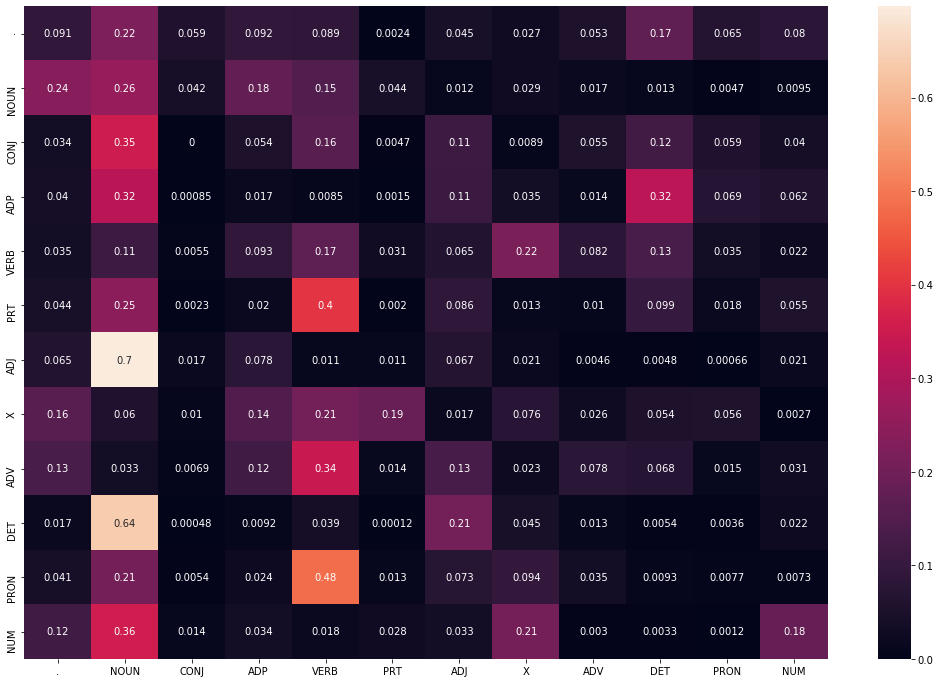

In [16]:
# heatmap of tags_matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df, annot = True)
plt.show()

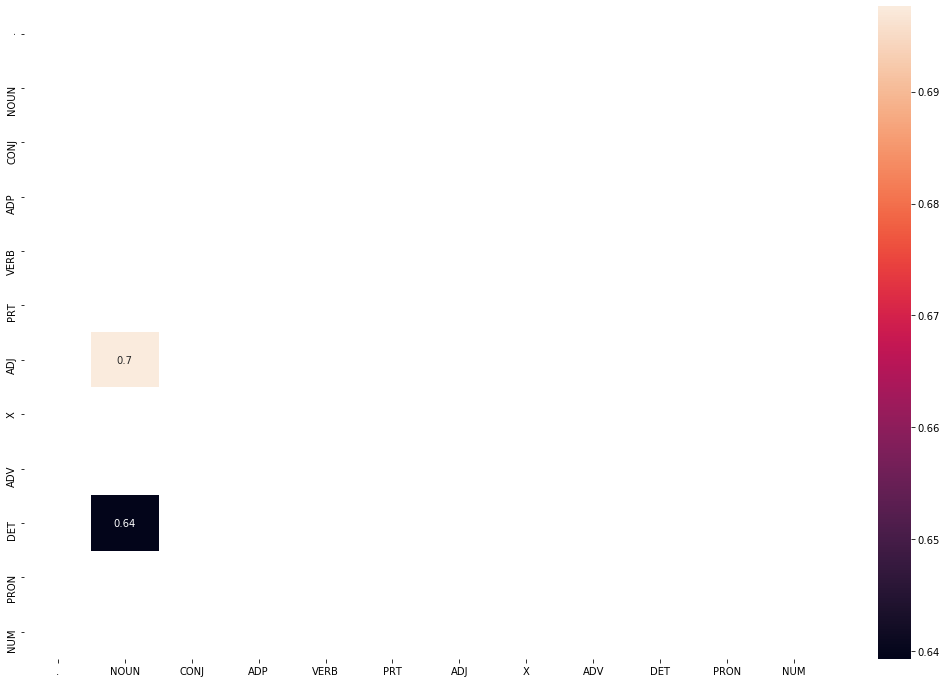

In [17]:
# frequent tags
# filter the tags_df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent, annot = True)
plt.show()

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.')

In [18]:
# Vanilla Viterbi Heuristic

def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Evaluation on Test set

In [19]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
#test_run = [test_set[i] for i in rndom]
test_run = test_set

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('``', '.'),
  ('Whether', 'ADP'),
  ('you', 'PRON'),
  ('thought', 'VERB'),
  ('0', 'X'),
  ('the', 'DET'),
  ('economy', 'NOUN'),
  ('was', 'VERB'),
  ('growing', 'VERB'),
  ('weak', 'ADJ'),
  ('or', 'CONJ'),
  ('holding', 'VERB'),
  ('*', 'X'),
  ('steady', 'ADJ'),
  (',', '.'),
  ('yesterday', 'NOUN'),
  ("'s", 'PRT'),
  ('economic', 'ADJ'),
  ('indicators', 'NOUN'),
  ('did', 'VERB'),
  ("n't", 'ADV'),
  ('change', 'VERB'),
  ('your', 'PRON'),
  ('opinion', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('said', 'VERB'),
  ('*T*-1', 'X'),
  ('Charles', 'NOUN'),
  ('Lieberman', 'NOUN'),
  (',', '.'),
  ('a', 'DET'),
  ('managing', 'VERB'),
  ('director', 'NOUN'),
  ('at', 'ADP'),
  ('Manufacturers', 'NOUN'),
  ('Hanover', 'NOUN'),
  ('Securities', 'NOUN'),
  ('Corp', 'NOUN'),
  ('.', '.')],
 [('This', 'DET'),
  ('phrase', 'NOUN'),
  ('once', 'ADV'),
  ('again', 'ADV'),
  ('is', 'VERB'),
  ('found', 'VERB'),
  ('*-49', 'X'),
  ('throughout', 'ADP'),
  ('the', 'DET'),
  ('many', 'ADJ'),
 

#### Check for the Accuracy

__Utility functions for obtaining accuracy and finding incorrect words__

In [20]:
# A utility mrthod to check accuracy of test data set which is taking corresponding tagged sequence as input

def accuracy(tagged_seq):
    tagged_seq = tagged_seq

    # Accuracy
    Viterbi_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
    accuracy = (len(Viterbi_check)/len(tagged_seq))*100
    return accuracy

In [21]:
# Method for checking the incorrect tagged words which is taking corresponding tagged sequence as input 

def incorrect(tagged_seq):
    incorrect_tagged_words = [j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

    print("Total Incorrect Tagged Words : ", len(incorrect_tagged_words))
    print("\n")
    print("Incorrect Tagged Words : ", incorrect_tagged_words)

__Tagging Accuracy Vanilla Viterbi__

In [22]:
# Accuracy for Vanilla Viterbi
tagged_seq_Viterbi = Viterbi(test_tagged_words)
accuracy_Viterbi = accuracy(tagged_seq_Viterbi)
print("Accuracy obtained by applying Vanilla Viterbi is: ", accuracy_Viterbi)

Accuracy obtained by applying Vanilla Viterbi is:  90.05825242718447


In [23]:
# Check for the incorrect tagged words
incorrect(tagged_seq_Viterbi)

Total Incorrect Tagged Words :  512


Incorrect Tagged Words :  [(('Whether', '.'), ('Whether', 'ADP')), (('Hanover', '.'), ('Hanover', 'NOUN')), (('Income', '.'), ('Income', 'NOUN')), (('robustly', '.'), ('robustly', 'ADV')), (('Gates', '.'), ('Gates', 'NOUN')), (('language-housekeeper', '.'), ('language-housekeeper', 'ADJ')), (('Gates', '.'), ('Gates', 'NOUN')), (('billionaire', '.'), ('billionaire', 'NOUN')), (('adapted', '.'), ('adapted', 'VERB')), (('that', 'ADP'), ('that', 'DET')), (('standard', 'ADJ'), ('standard', 'NOUN')), (('smooth', '.'), ('smooth', 'ADJ')), (('needle-like', '.'), ('needle-like', 'ADJ')), (('that', 'ADP'), ('that', 'DET')), (('classified', '.'), ('classified', 'VERB')), (('amphobiles', '.'), ('amphobiles', 'NOUN')), (('Brooke', '.'), ('Brooke', 'NOUN')), (('pathlogy', '.'), ('pathlogy', 'NOUN')), (('Vermont', '.'), ('Vermont', 'NOUN')), (('292.32', '.'), ('292.32', 'NUM')), (('263.07', '.'), ('263.07', 'NUM')), (('momentary', '.'), ('momentary', 'ADJ')), (('

### Solve the problem of unknown words

In [24]:
# Let's have a look at the unknown words which are present in test set but not present in training set
# Unknown words 

test_vocab_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocab_set - train_vocab_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 364


Unknown Words : ['third-highest', 'Photography', 'American-made', 'rivals', '41.60', 'airline-related', 'Offering', 'adapted', 'wrists', '*-134', 'planes', 'Assistant', 'Thai', 'gambler', 'nonrecurring', 'Traditionally', 'warming', 'inheritor', 'momentary', 'Arizona', 'Rae', 'Mayer', 'fetching', 'achieving', 'Everything', '1.61', 'retentive', 'Change-ringing', 'Xiaoping', 'eight-month', 'Kingsbridge', 'adjustments', 'lab', 'dexterity', 'battery-operated', 'carefree', 'Brunswick', 'Brent', 'scholarly', 'Fahrenheit', 'memo', 'diversionary', '380', 'Merrick', 'Shugart', 'predispose', 'GOODY', 'Survey', 'contributions', 'preferences', 'pediatrician', '*-146', 'overriding', 'remarks', 'Pramual', 'Hayne', 'absolute', 'platinum', 'versus', 'oust', 'rocket', 'composed', '5.3', '30.9', 'Marchese', '263.07', 'high-balance', '154.2', 'Rouge', '24,000', 'Somerset', 'invite', 'symbolic', 'Logic', 'billionaire', 'vow', 'supreme', 'divest', 'overcrowding', 'Deng', '86.12',

### Modifications on Viterbi 

#### Case 1. In case of unknown words the emission probability will be zero. So we will add a lambda to it for Laplace smoothing

In [25]:
# Method for modifying Viterbi algorithm by adding a lambda value of 0.0001(negligible) in case of zero emission probability

def Viterbi_Laplace(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            lm = 0.0001
            emission_p = (lm + word_given_tag(words[key], tag)[0])/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p 
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

__Evaluating Tagging Accuracy of Viterbi modified by Laplace smoothing__

In [26]:
# Accuracy obtained by applying Laplace smoothing in case of the presence of unknown words
tagged_seq_Viterbi_Laplace = Viterbi_Laplace(test_tagged_words)
accuracy_Viterbi_Laplace = accuracy(tagged_seq_Viterbi_Laplace)
print("Accuracy obtained after Laplace smoothing on Vanilla Viterbi for Unknown Words", accuracy_Viterbi_Laplace)

Accuracy obtained after Laplace smoothing on Vanilla Viterbi for Unknown Words 91.10679611650485


In [27]:
#Check for incorrect words
incorrect(tagged_seq_Viterbi_Laplace)

Total Incorrect Tagged Words :  458


Incorrect Tagged Words :  [(('Whether', 'CONJ'), ('Whether', 'ADP')), (('Hanover', '.'), ('Hanover', 'NOUN')), (('Income', 'PRON'), ('Income', 'NOUN')), (('robustly', 'VERB'), ('robustly', 'ADV')), (('Gates', '.'), ('Gates', 'NOUN')), (('language-housekeeper', 'NOUN'), ('language-housekeeper', 'ADJ')), (('Gates', 'PRON'), ('Gates', 'NOUN')), (('billionaire', '.'), ('billionaire', 'NOUN')), (('adapted', '.'), ('adapted', 'VERB')), (('that', 'ADP'), ('that', 'DET')), (('standard', 'ADJ'), ('standard', 'NOUN')), (('needle-like', 'CONJ'), ('needle-like', 'ADJ')), (('that', 'ADP'), ('that', 'DET')), (('classified', 'X'), ('classified', 'VERB')), (('amphobiles', 'DET'), ('amphobiles', 'NOUN')), (('Brooke', 'VERB'), ('Brooke', 'NOUN')), (('pathlogy', 'DET'), ('pathlogy', 'NOUN')), (('Vermont', 'DET'), ('Vermont', 'NOUN')), (('292.32', 'VERB'), ('292.32', 'NUM')), (('263.07', 'DET'), ('263.07', 'NUM')), (('momentary', 'DET'), ('momentary', 'ADJ')), (('Trad

#### Case 2. Modified Viterbi with Rule based approach

__First we will try with Lexicon(Unigram Tagger) approach followed by ,Rule Based, Bigram Tagger, Trigram Tagger.__

In [28]:
# Unigram Tagger

unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", accuracy_unigram_tagger)

The accuracy of the Unigram Tagger is - 0.9011650485436893


__Rule Based Approach where we are defining some grammer rules.__

In [29]:
# Rules for correcting the POS tags

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),           # possessive nouns
    (r'.*s$', 'NOUN'),             # plural nouns  
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'),     # Any special character combination
    (r'.*ould$', 'X'),             # modals
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'),  
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
    (r'.+(-.+)+', 'ADJ'),
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'^[-]?[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
    (r'^\'*[0-9]+(.[0-9]+)?$', 'NUM'),
    (r'.*', 'NOUN')
    ]

__Unigram Tagger backed off by Rule based approach__

In [30]:
# rule based tagger 

rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger backed up by the RegexpTagger is -", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger backed up by the RegexpTagger is - 0.96


__Bigram Tagger backed off by Rule based unigram tagger__

In [31]:
# Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff=rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger backed up by the RegexpTagger is - ",accuracy_bigram_tagger)

The accuracy of the Bigram Tagger backed up by the RegexpTagger is -  0.9636893203883495


__Trigram tagger backed off by Bigram Tagger which in turn backed off by Rule based Unigram Tagger__

In [32]:
# Trigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Trigram Tagger backed up by the RegexpTagger is -", accuracy_trigram_tagger)

The accuracy of the Trigram Tagger backed up by the RegexpTagger is - 0.9646601941747572


As we have tried multiple approaches here we could see that the accuracy obtained by trigram with rule based approach is maximum so I will be choosing this approach along with Vanilla Viterbi for enhancing the performance of my model.

__Modified Viterbi with Trigram tagger backed off by bigram tagger which is again backed up by rule based unigram tagger approach__

In [33]:
# Method for modified Viterbi algorithm where we will be identifying the POS tag by Trigram tagger 
# (which in turn backed up by rule based approach)

def Viterbi_trigram_backed_by_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        if word not in train_vocab_set:
            state_max = trigram_tagger.tag([word])[0][1]
        else:
            #initialise list of probability column for a given observation
            p = []
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]

                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
        
    return list(zip(words, state))

__Evaluating tagging accuracy of Viterbi modified by Trigram tagger backed by rule based__

In [34]:
# Accuracy obtained after applying trigram tagger for unknown words defined above
tagged_seq_Viterbi_trigram_backed_by_rule_based = Viterbi_trigram_backed_by_rule_based(test_tagged_words)
accuracy_Viterbi_Trigram_rule_based = accuracy(tagged_seq_Viterbi_trigram_backed_by_rule_based)
print("Accuracy obtained after modifying Viterbi with Trigram tagger backed by rule based for unknown words: ", accuracy_Viterbi_Trigram_rule_based)

Accuracy obtained after modifying Viterbi with Trigram tagger backed by rule based for unknown words:  96.0


In [35]:
# Identifying incorrect words
incorrect(tagged_seq_Viterbi_trigram_backed_by_rule_based)

Total Incorrect Tagged Words :  206


Incorrect Tagged Words :  [(('Whether', 'NOUN'), ('Whether', 'ADP')), (('that', 'ADP'), ('that', 'DET')), (('standard', 'ADJ'), ('standard', 'NOUN')), (('smooth', 'NOUN'), ('smooth', 'ADJ')), (('that', 'ADP'), ('that', 'DET')), (('momentary', 'NOUN'), ('momentary', 'ADJ')), (('calls', 'VERB'), ('calls', 'NOUN')), (('homosexual', 'NOUN'), ('homosexual', 'ADJ')), (('returns', 'NOUN'), ('returns', 'VERB')), (('building', 'VERB'), ('building', 'NOUN')), (('buy-out', 'NOUN'), ('buy-out', 'ADJ')), (('earlier', 'ADV'), ('earlier', 'ADJ')), (('divest', 'NOUN'), ('divest', 'VERB')), (('enough', 'ADV'), ('enough', 'ADJ')), (('most', 'ADJ'), ('most', 'ADV')), (('funding', 'NOUN'), ('funding', 'VERB')), (('4', 'NUM'), ('4', 'X')), (('pay', 'VERB'), ('pay', 'NOUN')), (('British', 'ADJ'), ('British', 'NOUN')), (('diversionary', 'NOUN'), ('diversionary', 'ADJ')), (('symbolic', 'NOUN'), ('symbolic', 'ADJ')), (('offer', 'VERB'), ('offer', 'NOUN')), (('fault', 'NOUN

__Evaluating on sample text file__

In [36]:
# Reading the sample text file
file = open('Test_sentences.txt')
text = file.read()
sample_test_sent = text.splitlines()
file.close()

#Lets have a glimpse at the sentences
sample_test_sent

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [37]:
# list of untagged words
sample_test_words = [word for sent in sample_test_sent for word in sent.split()]

In [38]:
# call plain viterbi algo
V_plain=Viterbi(sample_test_words)

# call rule based viterbi algo
V_mod=Viterbi_trigram_backed_by_rule_based(sample_test_words)

# create a temp array to store the results
temp=[[i[0], i[1], j[1]] for i,j in zip(V_plain, V_mod)]

In [39]:
# create a dataframe to compare results of both algorithms
tag_diff = pd.DataFrame(temp, columns=['word','Viterbi_plain','Viterbi_mod'])
tag_diff

,word,Viterbi_plain,Viterbi_mod
0,Android,.,NOUN
1,is,VERB,VERB
2,a,DET,DET
3,mobile,ADJ,ADJ
4,operating,NOUN,NOUN
5,system,NOUN,NOUN
6,developed,VERB,VERB
7,by,ADP,ADP
8,Google.,.,NOUN
9,Android,.,NOUN


__Observation:__
1. We can see that with modified rule based Viterbi algorithm words like Android, Google has been correctly identified as NOUN.
2. Also numbers like 2011, 2013 has been correctly identified now as NUM.
3. words like 'arriving;, 'invited' got corrected to VERB.

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [40]:
# a dataframe for comparing accuracies of various algorithms
acccuracy_data = [['Vanilla Viterbi', accuracy_Viterbi], 
                  ['Vanilla Viterbi Modified with Laplace', accuracy_Viterbi_Laplace], 
                  ['Viterbi modified by Trigram_tagger backed up by Rule based', accuracy_Viterbi_Trigram_rule_based]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,90.058252
Vanilla Viterbi Modified with Laplace,91.106796
Viterbi modified by Trigram_tagger backed up by Rule based,96.000000


__As observed we are getting the best accuracy on Viterbi algorithm which is modified for identifying unknown words by Trigram tagger technique backed up by rule based approach__

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [41]:
# method for listing down the words which were incorrectly identified by Vanilla Viterbi and got corrected later 
# by the modifications
def CorrectedWords(tagged_seq_Viterbi, tagged_seq_Viterbi_mod, test_run_base=test_run_base):
    corrected = pd.DataFrame(tagged_seq_Viterbi, columns=['word', 'Tag_Vanilla_Viterbi'])
    corrected['Tag_mod_Viterbi']=pd.DataFrame(tagged_seq_Viterbi_mod).loc[:,1]
    corrected['correct_tag']=pd.DataFrame(test_run_base).loc[:,1]
    corrected.set_index('word', drop = True, inplace = True)
    return corrected[(corrected['Tag_Vanilla_Viterbi']!=corrected['Tag_mod_Viterbi']) &
                     (corrected['Tag_mod_Viterbi']==corrected['correct_tag'])]


In [42]:
CorrectedWords(tagged_seq_Viterbi, tagged_seq_Viterbi_trigram_backed_by_rule_based)

,Tag_Vanilla_Viterbi,Tag_mod_Viterbi,correct_tag
word,,,
Hanover,.,NOUN,NOUN
Income,.,NOUN,NOUN
robustly,.,ADV,ADV
Gates,.,NOUN,NOUN
language-housekeeper,.,ADJ,ADJ
...,...,...,...
98.3,.,NUM,NUM
crashing,.,VERB,VERB
Brent,.,NOUN,NOUN


__Above is the dataframe of all the tags which were correctly identified by modified Viterbi algorithm__